# 类激活图（CAM）的动态可视化

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50, VGG16, InceptionV3
from keras.applications.vgg16 import preprocess_input, decode_predictions
# from utils import make_parallel
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


## 1. 载入训练集

- 从硬盘读取25000张猫狗图片，存入data
- 定义训练集配套的图片类型标签，存入label
- 将训练集进一步划分为训练集和验证集

In [2]:
path = os.getcwd() + '\\train\\'
label = np.array([0] * 12500 + [1] * 12500)
data = np.zeros((25000, 224, 224, 3), dtype=np.uint8)

for i in tqdm(range(12500)):
    img = cv2.imread(path + 'cat\\' + str(i) + '.jpg')
    img = img[:, :, ::-1]
    img = cv2.resize(img, (224, 224))
    data[i] = img
    
for i in tqdm(range(12500)):
    img = cv2.imread(path + 'dog\\' + str(i) + '.jpg')
    img = img[:, :, ::-1]
    img = cv2.resize(img, (224, 224))
    data[i+12500] = img
    
print('Training Data Size = %.2f GB' % (sys.getsizeof(data)/1024**3))

100%|███████████████████████████████████████████████████| 12500/12500 [00:28<00:00, 441.23it/s]


Training Data Size = 3.50 GB


In [3]:
X_train, X_val, y_train, y_val = train_test_split(data, label, shuffle=True, test_size=0.2, random_state=42)

## 2. 创建模型

- 基模型直接使用只含卷积层部分的预训练 `VGG16` 模型
- 在基模型的基础上追加GAP、Dropout、Dense，即分类器部分
- 由于要解决的是二分类问题，因此使用 `binary_crossentropy` 作为损失函数，y也不用 one-hot 编码了
- 采用 Transfer Learning 策略：锁定 base_model 所有层的参数，仅允许训练分类器部分的参数（只有512+1=513个参数）


In [4]:
base_model = VGG16(include_top=False, weights='imagenet')
for layers in base_model.layers:
    layers.trainable = False
y = GlobalAveragePooling2D()(base_model.output)
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
from keras import backend as K

def get_params_count(model):
    trainable = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
    return trainable, non_trainable

print('Trainable Parameters: ', get_params_count(model)[0])

Trainable Parameters:  513


## 3. 训练模型

- 想要看到模型”成长的过程“，就需要了解模型在每个Batch后权重更新的状态。具体在这里，由于由于模型的卷积层参数已经冻结，并不会对模型的成长有任何贡献，因此实际上模型的进化过程完全由输出层的这513个权重参数决定。

- 具体实现上，我们需要定义一个Lambda Callback，用来备份在每个batch结束时最后一层的权重数值。

- 模型仅经过一代训练就可以达到 94.5% 的验证集准确率，我们应该能在稍后的处理之后欣赏到模型从50%上升到94.5%的完整心路历程。

In [6]:
from keras.callbacks import LambdaCallback
weights_history = []
get_weights_cb = LambdaCallback(on_batch_end=lambda batch, 
                                logs: weights_history.append(model.layers[-1].get_weights()[0]))

In [7]:
history = model.fit(x=X_train, y=y_train, 
                    batch_size=16, 
                    epochs=1, 
                    validation_data=(X_val, y_val), 
                    callbacks=[get_weights_cb])

Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 224s - loss: 0.5052 - acc: 0.8843 - val_loss: 0.1615 - val_acc: 0.9518


In [6]:
import pickle
with open('weights_history.p', 'wb') as f:
    pickle.dump(weights_history, f)

In [7]:
with open('weights_history.p', 'rb') as f:
    lalala = pickle.load(f)

## 4. 权重处理

- 输入的图像先变成**特征图**（Feature Maps），再变成**特征向量**（Feature Vector），最后变成**分类概率值**。

    - 具体来说，由于 VGG16 的最后一层卷积层含有512个卷积核，因此会输出512张特征图。每张特征图代表了对应的卷积核眼中的输入图像。

    - 经过GAP，512张特征图被浓缩简化成一个具有512个元素的特征向量，经过权重矩阵 $W$ 加权后送入 Sigmoid 函数，映射为[0, 1]区间内的概率值。

$$
\begin{matrix}
\mathbf{Model ~ Input} & \stackrel{\color{blue}{\mathrm{CONV}}}{\longrightarrow} & \mathbf{CONV ~ Output} & \stackrel{\color{green}{\mathrm{GAP}}}{\longrightarrow} & \mathbf{GAP ~ Output} & \stackrel{\color{red}{W^{(512)}}}{\longrightarrow} & \mathbf{Dense} ~ \mathrm{(Sigmoid)} ~ \mathbf{Output}\\[3ex]
\Big[224, ~224, ~3\Big] && \Big[7, ~7, ~512\Big] && \Big[~512~\Big] && \Big[~1~\Big]  \\[3ex]
\mathrm{(Image ~ Data)} && \mathrm{(Feature ~Maps)} && \mathrm{(Feature ~ Vector)} && \mathrm{(Probability \in [0, 1])}
\end{matrix}
$$

- 对于同一张图片，由于基模型恒定不变，因此 $\mathbf{CONV ~ Output}$（特征图集 Feature Maps）固定不变， 也就是下面的 out_base
- 从 $\mathbf{CONV ~ Output}$ 到最后预测的概率值还要先经过全局平均池化、乘以权重、经过Sigmoid这三步才能得到，直接用下面的函数手动实现了下

In [8]:
target = data[1][:, :, ::-1]

In [9]:
out_base = base_model.predict(np.expand_dims(target, axis=0))
out_base = out_base[0]
print(out_base.shape)

(7, 7, 512)


In [10]:
# 根据卷积层输出特征图集和模型某一参数状态计算预测概率（为了简单省略了bias计算）
def predict_on_weights(out_base, weights):
    gap = np.average(out_base, axis=(0, 1))
    logit = np.dot(gap, np.squeeze(weights))
    return 1 / (1 +  np.e ** (-logit))

predict_on_weights(out_base, weights_history[42])

1.3764483869306829e-05

## 5. 类激活图计算

- #### CAM的工作原理

    - 由于整个模型在训练时，会发生变化的参数只有分类器的权重矩阵 $W$，因此对于同一张图片，卷积层输出的特征图集始终不变，但分类概率会随着 $W$ 的变化而不断改变，这也就是模型学习的过程，即：到底哪些特征图对于提高分类准确率最有帮助？

    - 可以看到，模型做出分类决策的依据来源于 $W$ 矩阵。那么如何进行可视化呢？ $W$ 矩阵本身并不直观。这里我们可以注意到，由于 $W$ 矩阵对图像的理解是基于对特征向量的加权，而特征向量背后是一个个特征图，因此可以跳过特征向量，直接将这些特征图用 $W$ 加权，再重叠合成为一张特征图，就可以很直观的看到到底模型是通过看哪片区域来做出判断的。
    
    - 举例来说，对于一张猫咪的图片，刚开始训练时，$W$ 的值还是初始化的值，此时模型听信 $W$ 矩阵，选择了第10/20/30号特征图作为判断依据，判断图像 84% 是狗。由于这么预测的Loss很大，因此在后续反向传播的时候不断更新 $W$ 矩阵，开始逐渐以第99/100/101号等特征图作为判断依据，直到能够判断图像 100% 是猫的时候，模型基本上就学会了如何判断猫狗。


- #### 基本流程
    
    - **归一化**：由于ColorMap的工作原理是将任意矩阵的取值范围映射到0~255范围内，因此为了之后好挑选颜色，需要归一化一下。
    
    - 手动放大至[0,255]
    
    - 元素格式化
    
    - **设定门限**：由于只希望将模型认为比较重要的区域标记出来，因此应该选择一个门限值，将该门限值之下的像素置 0（将该像素透明化）
    
    - 将源图像与热图合成为一张图
    
    - 在图像本体添加文字标注（方便之后导出为视频）

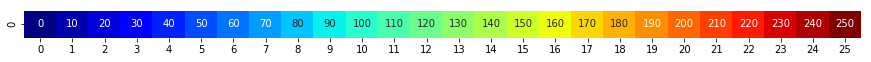

In [11]:
import seaborn as sns
plt.figure(figsize=(15, 0.5))
band = np.array([list(np.arange(0, 255, 10))] * 1)
sns.heatmap(band, annot=True, fmt="d", cmap='jet', cbar=False)
plt.show()

In [12]:
def getCAM(weights, display=False):
    
    predict = predict_on_weights(out_base, weights)
    
    # Weighted Feature Map
    cam = (predict - 0.5) * np.matmul(out_base, weights)
    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    # Resize as image size
    cam_resize = cv2.resize(cam, (224, 224))
    # Format as CV_8UC1 (as applyColorMap required)
    cam_resize = 255 * cam_resize
    cam_resize = cam_resize.astype(np.uint8)
    # Get Heatmap
    heatmap = cv2.applyColorMap(cam_resize, cv2.COLORMAP_JET)
    # Zero out
    heatmap[np.where(cam_resize <= 100)] = 0
    
    out = cv2.addWeighted(src1=target, alpha=0.8, src2=heatmap, beta=0.4, gamma=0)
    out = cv2.resize(out, dsize=(500, 500))
    
    if predict < 0.5:
        text = 'cat %.2f%%' % (100 - predict * 100)
    else:
        text = 'dog %.2f%%' % (predict * 100)
        
    cv2.putText(out, text, (290, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, 
                  color=(123,222,238), thickness=2, lineType=cv2.LINE_AA)
    if display:
        plt.imshow(out[:, :, ::-1])
        plt.show()
    return out

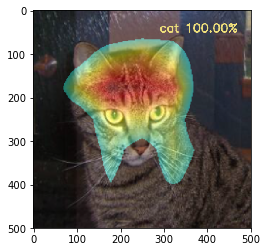

In [13]:
getCAM(weights_history[1000], display=True);

## 6. 导出视频

- 视频本质上就是一个快速播放的图片幻灯片，所以不断调用getCAM并写入VideoWriter就可以了。
- 使用VideoWriter生成视频，为了方便在iOS上播放，这里使用的是MP4V的编码格式。

In [14]:
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output2.mp4',fourcc, 20.0, (500, 500))

for weight in weights_history:
    img = getCAM(weight)
    out.write(img)
    cv2.imshow('frame', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()

![image](https://github.com/mtyylx/MLND/blob/master/P6_Dogs_VS_Cats/output.gif?raw=true)
![image](https://github.com/mtyylx/MLND/blob/master/P6_Dogs_VS_Cats/output2.gif?raw=true)

## 7. 总结

通过生成的视频可以看到一些有趣的现象。

- 每次从头训练看到的模型学习过程都不太一样，比如有的时候一开始识别为狗，有的时候一上来就蒙对了。这应该是由 $W$ 初始化值不同导致的。


- 从上面的动图可以看到，模型一开始主要关注的区域（红色）比较靠上，包括了耳朵和额头，但是随着模型看到的各式猫狗图片越来越多，模型的注意力慢慢的开始向下移动，耳朵的重要性慢慢下降，同时也开始涉猎胡子区域。下面是一些不负责任的无脑猜测时间^_^：也许是模型发现耳朵并不是一个区分猫狗的很好依据，毕竟有些品种的猫狗耳朵十分类似。还有就是胡子变得重要起来可能是因为猫的胡子比狗要长一些，而且具有实际的功能：猫胡子可以过的地方，猫身体就可以通过等等。


- 另外需要注意的是，由于模型对于不同图片的特征图是不同的，因此模型看不同图片的区域也是不同的。

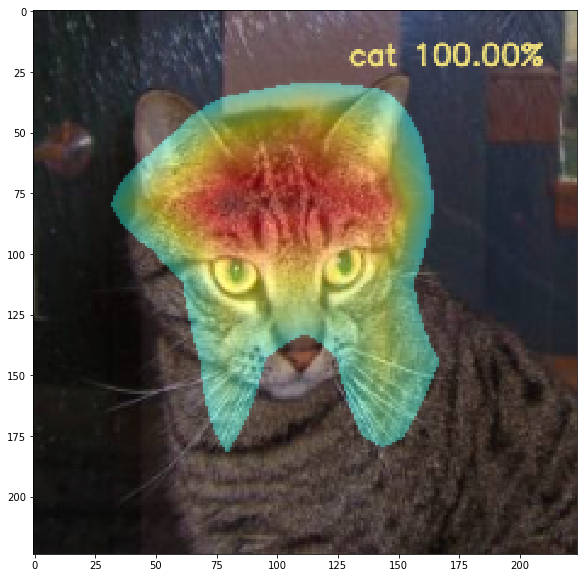

In [18]:
weights = weights_history[1249]
predict = predict_on_weights(out_base, weights)

# Weighted Feature Map
cam = (predict - 0.5) * np.matmul(out_base, weights)
# Normalize
cam = (cam - cam.min()) / (cam.max() - cam.min())
# Resize as image size
cam_resize = cv2.resize(cam, (224, 224))
# Format as CV_8UC1 (as applyColorMap required)
cam_resize = 255 * cam_resize
cam_resize = cam_resize.astype(np.uint8)
# Get Heatmap
heatmap = cv2.applyColorMap(cam_resize, cv2.COLORMAP_JET)
# Zero out
heatmap[np.where(cam_resize <= 100)] = 0

out = cv2.addWeighted(src1=target, alpha=0.8, src2=heatmap, beta=0.4, gamma=0)
out = cv2.resize(out, dsize=(500, 500))

if predict < 0.5:
    text = 'cat %.2f%%' % (100 - predict * 100)
else:
    text = 'dog %.2f%%' % (predict * 100)

cv2.putText(out, text, (290, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, 
              color=(123,222,238), thickness=2, lineType=cv2.LINE_AA)
out = cv2.resize(out, dsize=(224, 224))
plt.figure(figsize=(10, 10))
plt.imshow(out[:, :, ::-1])
plt.show()